In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')

The Data

In [46]:
df = pd.read_csv('data/train.csv')
df.dropna(inplace=True)
df.shape

(1017209, 9)

<Axes: >

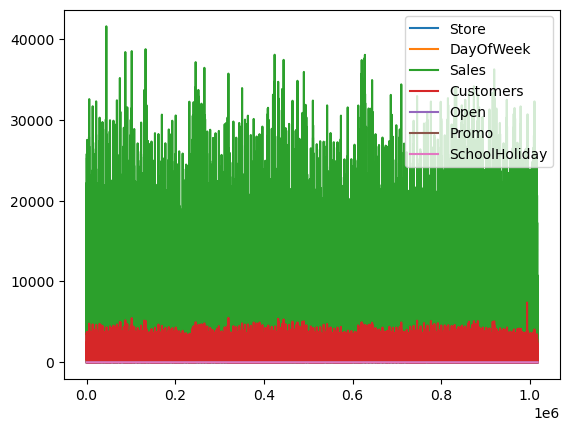

In [47]:
df.plot()

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [49]:
df_g_s = df.query("DayOfWeek == 7 and Open == 1").groupby(['Store','DayOfWeek'])[['Sales']]
df_g_s.value_counts()

Store  DayOfWeek  Sales
85     7          11528    2
                  7303     1
                  13194    1
                  13267    1
                  13275    1
                          ..
1099   7          4698     1
                  4703     1
                  4761     1
                  4812     1
                  7465     1
Name: count, Length: 3535, dtype: int64

In [50]:
stores_df = df.set_index(pd.to_datetime(df['Date'])).drop('Date', axis = 1)

In [51]:
stores_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1
2013-01-01,1112,2,0,0,0,0,a,1
2013-01-01,1113,2,0,0,0,0,a,1


In [52]:
store_1 = stores_df[(stores_df['Store'] == 209)][['Sales']]
store_1.dropna(inplace=True)
store_1.sort_index(inplace=True)

In [53]:
store_1.head()

,Sales
Date,
2013-01-01,0
2013-01-02,5838
2013-01-03,5703
2013-01-04,5417
2013-01-05,3964


<Axes: title={'center': 'Store Daily Sales vs time'}, xlabel='Date'>

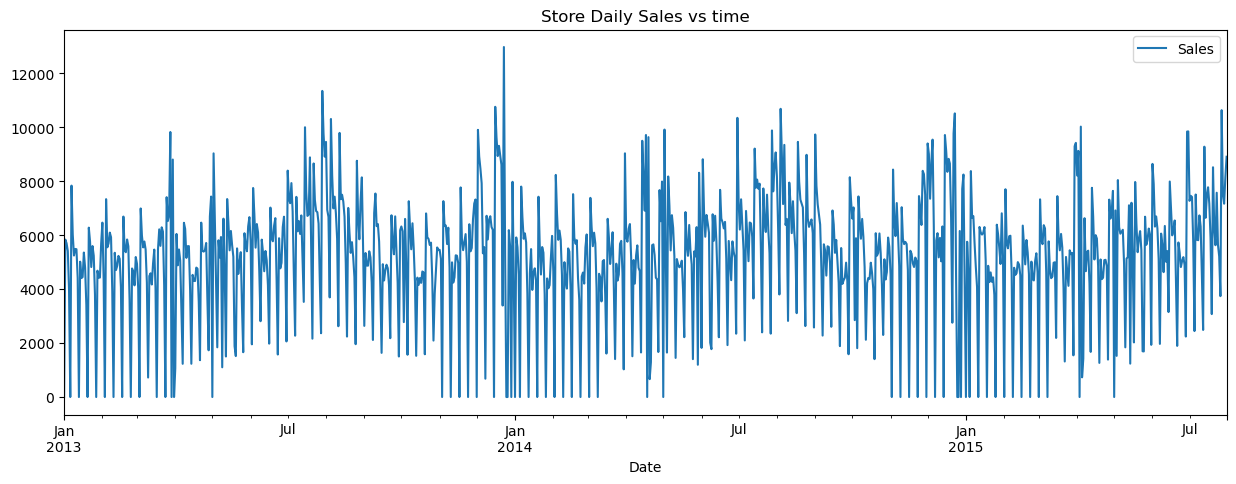

In [54]:
store_1.plot(figsize=(15,5), title='Store Daily Sales vs time')

#### Train/Test split

In [55]:
y_hist, y_future = train_test_split(store_1, shuffle=False)

In [56]:
# Answer check
print("History\n=========")
print(y_hist.tail())
print("Future\n==========")
print(y_future.head())

History
            Sales
Date             
2014-12-03   7355
2014-12-04   8713
2014-12-05   9547
2014-12-06   6305
2014-12-07      0
Future
            Sales
Date             
2014-12-08   5802
2014-12-09   6077
2014-12-10   5180
2014-12-11   5903
2014-12-12   5034


### Stationarity of residuals in a decomposition model

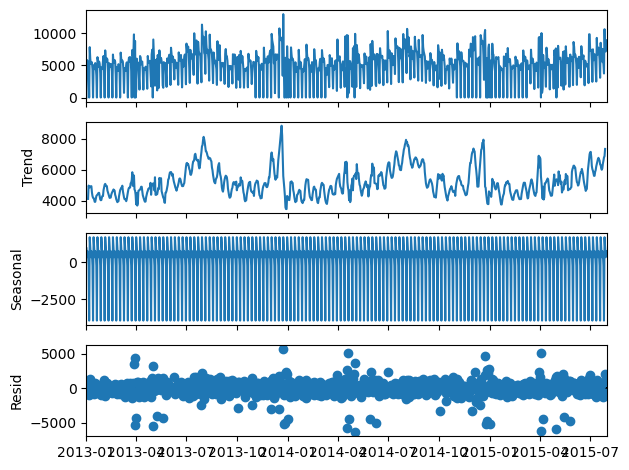

In [57]:
periods = 12
store_decmp = seasonal_decompose(store_1, model='additive')
store_decmp.plot();

Text(0.5, 1.0, 'Trend with Store Data')

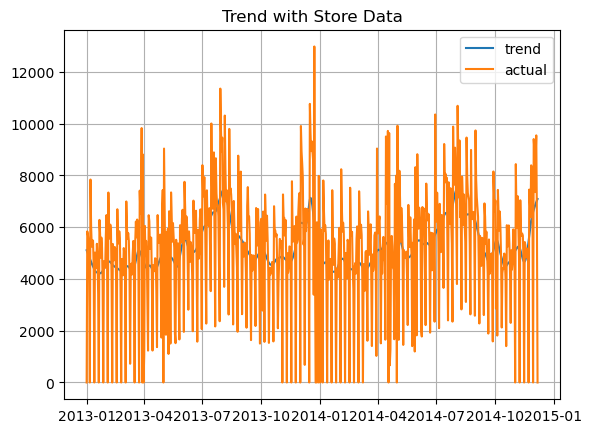

In [58]:
stl = STL(y_hist['Sales'], period = periods)
results = stl.fit()
## Answer check
plt.plot(results.trend, label = 'trend')
plt.plot(y_hist, label = 'actual')
plt.grid()
plt.legend()
plt.title('Trend with Store Data')

Yes
pval: 6.869675299404694e-17


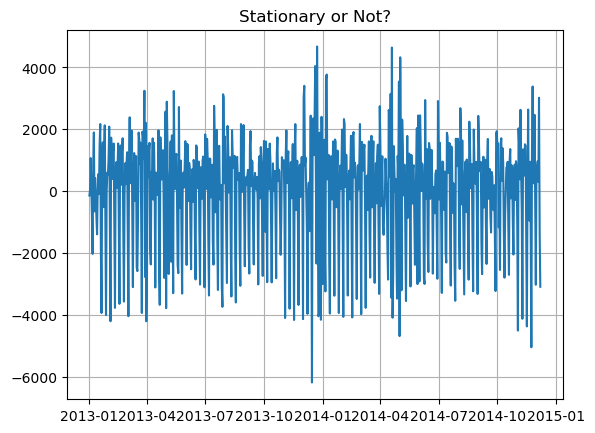

In [59]:
plt.plot(results.resid)
plt.grid()
plt.title('Stationary or Not?');
print('Yes' if adfuller(results.resid)[1] < 0.05 else 'Not')
print(f"pval: {adfuller(results.resid)[1]}")

pval: 0.06647406016645246
Stationary: Yes


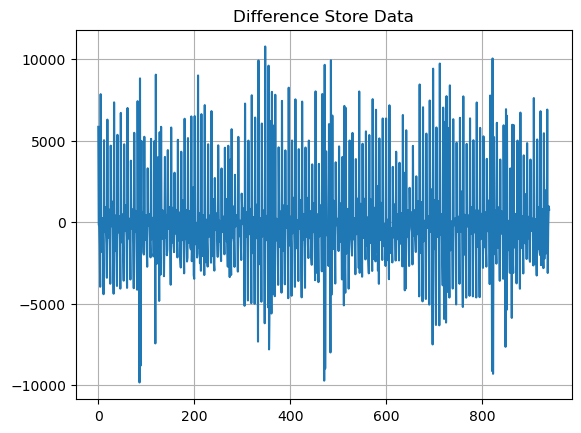

In [60]:
min_diff = store_1.diff().dropna()
plt.plot(min_diff.values)
plt.title('Difference Store Data')
plt.grid();
print(f"pval: {adfuller(y_hist)[1]}")
print(f"Stationary: {'Yes' if adfuller(min_diff)[1] < 0.05 else 'Not'}")

#### Assumptions of Linearity

In [61]:
pval = adfuller(y_hist)[1]
pval

0.06647406016645246

### Autocorrelation and Partial Autocorrelation

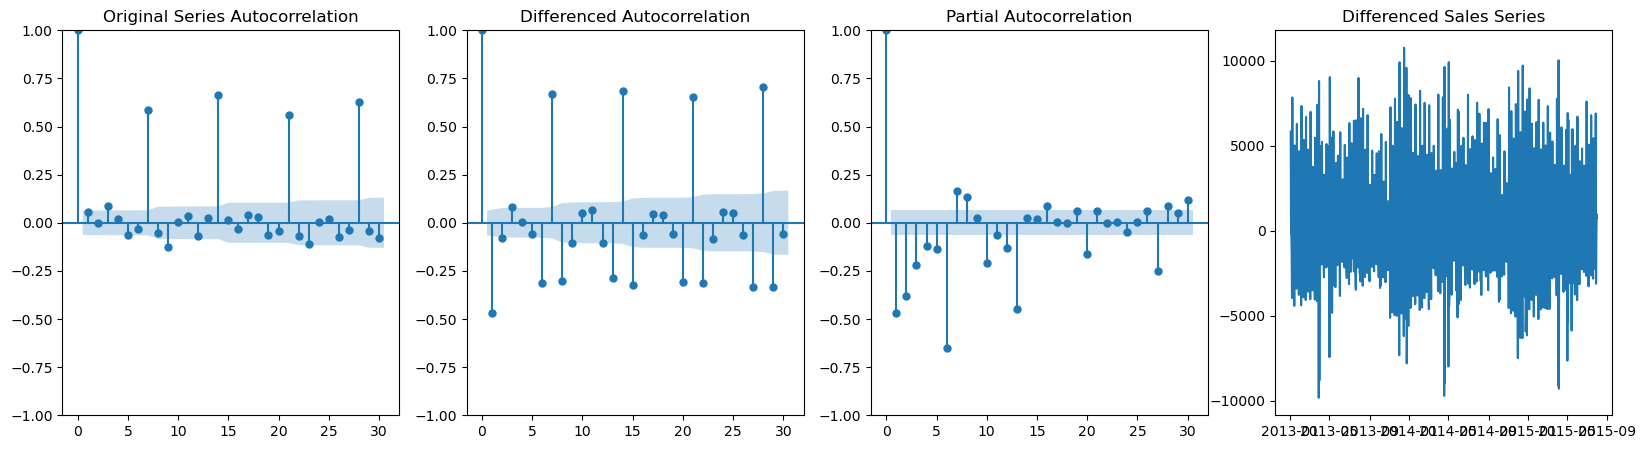

In [62]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
plot_acf(store_1, ax = ax[0]);
ax[0].set_title('Original Series Autocorrelation')
plot_acf(store_1.diff().dropna(), ax = ax[1]);
ax[1].set_title('Differenced Autocorrelation')
plot_pacf(store_1.diff().dropna(), ax = ax[2], method = 'ywm');
ax[3].plot(store_1.diff().dropna())
ax[3].set_title('Differenced Sales Series');

In [63]:
X_train, X_test = store_1.iloc[:-30], store_1.iloc[-30:]
arma = ARIMA(X_train.diff(), order = (2, 0, 2), freq = 'D').fit()
preds = arma.forecast(len(X_test))
mse_test = mean_squared_error(preds, X_test)
print(mse_test)

46406853.83946441


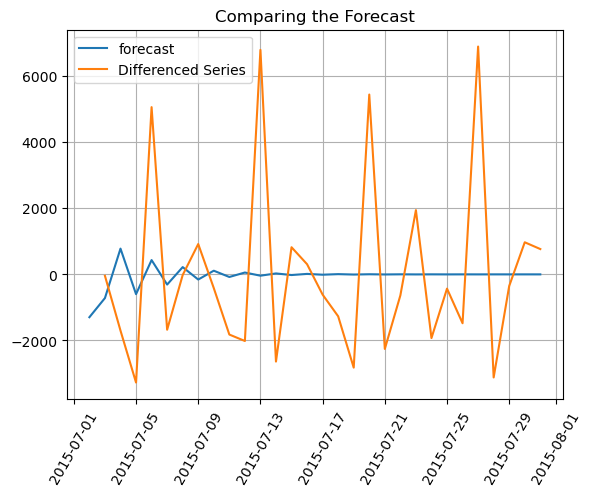

In [64]:
plt.plot(arma.forecast(steps = len(X_test)), label = 'forecast')
plt.plot(X_test.diff(), label = 'Differenced Series')
plt.title('Comparing the Forecast')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


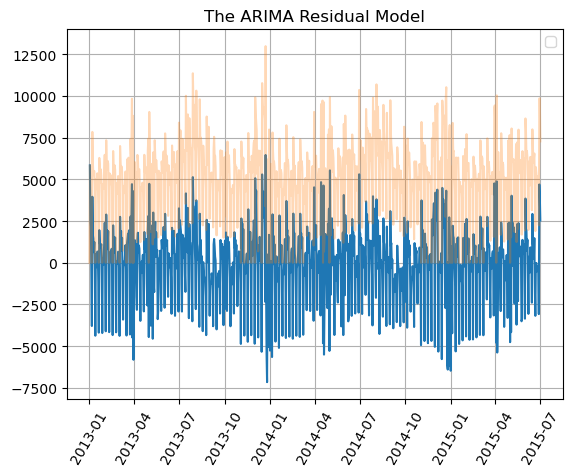

In [65]:
plt.plot(X_train.index, arma.resid)
plt.plot(X_train.index, X_train, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('The ARIMA Residual Model')
plt.legend()
plt.grid();

### A Model with Seasonality

In [66]:
X_train_z, X_test_z = store_1.iloc[-700:-30], store_1.iloc[-30:]
sarima = SARIMAX(X_train_z,  order=(2, 0, 2), seasonal_order=(2, 0, 2, 4)).fit(disp=0)
print(sarima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  670
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 4)   Log Likelihood               -6127.683
Date:                           Tue, 14 Nov 2023   AIC                          12273.366
Time:                                   19:52:32   BIC                          12313.932
Sample:                               08-31-2013   HQIC                         12289.079
                                    - 07-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1945      0.066      2.934      0.003       0.065       0.324
ar.L2          0.8041      0.066     12.273

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Model MAE: 1680.7089963498988
Model RMSE: 2239.184818848403
Model AICC: 12273.638860001236


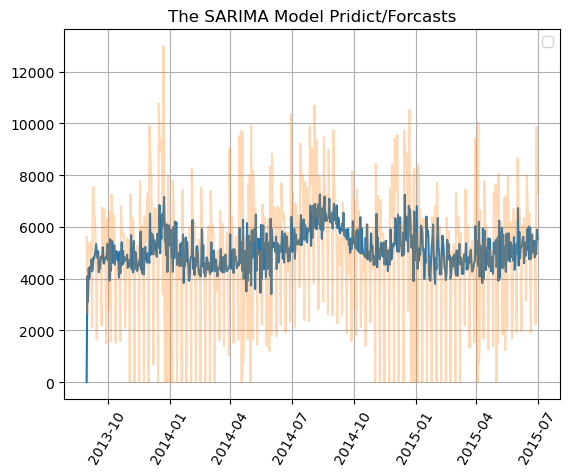

In [89]:
plt.plot(X_train_z.index, sarima.predict())
plt.plot(X_train_z.index, X_train_z, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('The SARIMA Model Pridict/Forcasts')
plt.legend()
plt.grid();
print(f"Model MAE: {sarima.mae}")
#print(f"Model MSE: {sarima.mse}")
print(f"Model RMSE: {np.sqrt(sarima.mse)}")
print(f"Model AICC: {sarima.aicc}")

In [68]:
dir(sarima)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_cov_params_approx',
 '_cov_params_oim',
 '_cov_params_opg',
 '_cov_params_robust_approx',
 '_cov_params_robust_oim',
 '_data_attr',
 '_data_attr_model',
 '_data_in_cache',
 '_fixed_params',
 '_fixed_params_index',
 '_free_params_index',
 '_get_previous_updated',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_has_fixed_params',
 '_init_kwds',
 '_news_previous_data',
 '_news_previous_results',
 '_news_updated_data',
 '_news_updated_results',
 '_params_ar',
 '_params_ma',
 '_params_seasonal_ar',
 '_params_seasonal_ma',
 '_pa

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


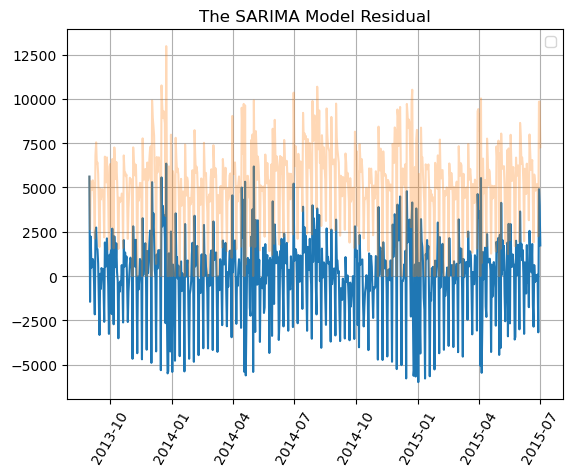

In [69]:
plt.plot(X_train_z.index, sarima.resid)
plt.plot(X_train_z.index, X_train_z, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('The SARIMA Model Residual')
plt.legend()
plt.grid();

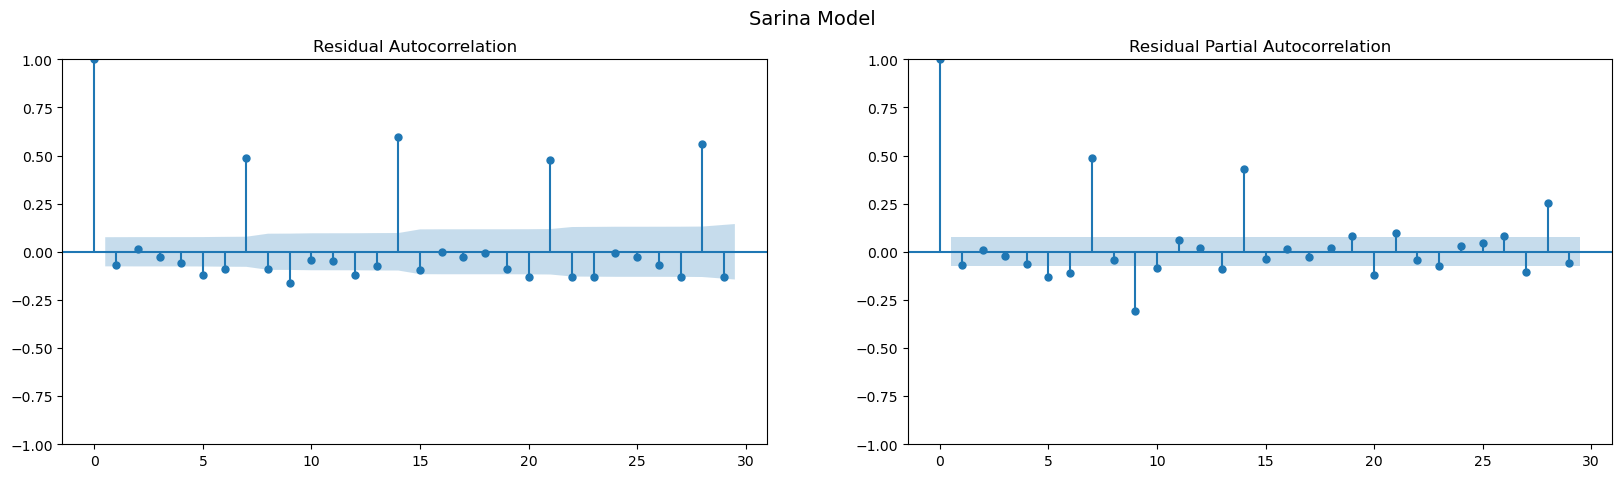

In [70]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))

plot_acf(sarima.resid, ax = ax[0]);
ax[0].set_title('Residual Autocorrelation')
plot_pacf(sarima.resid, ax = ax[1]);
ax[1].set_title('Residual Partial Autocorrelation')
fig.suptitle('Sarina Model', fontsize = 14, horizontalalignment='center')
plt.show()

In [71]:
dir(sarima)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_cov_params_approx',
 '_cov_params_oim',
 '_cov_params_opg',
 '_cov_params_robust_approx',
 '_cov_params_robust_oim',
 '_data_attr',
 '_data_attr_model',
 '_data_in_cache',
 '_fixed_params',
 '_fixed_params_index',
 '_free_params_index',
 '_get_previous_updated',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_has_fixed_params',
 '_init_kwds',
 '_news_previous_data',
 '_news_previous_results',
 '_news_updated_data',
 '_news_updated_results',
 '_params_ar',
 '_params_ma',
 '_params_seasonal_ar',
 '_params_seasonal_ma',
 '_pa

### Examining acf and pacf

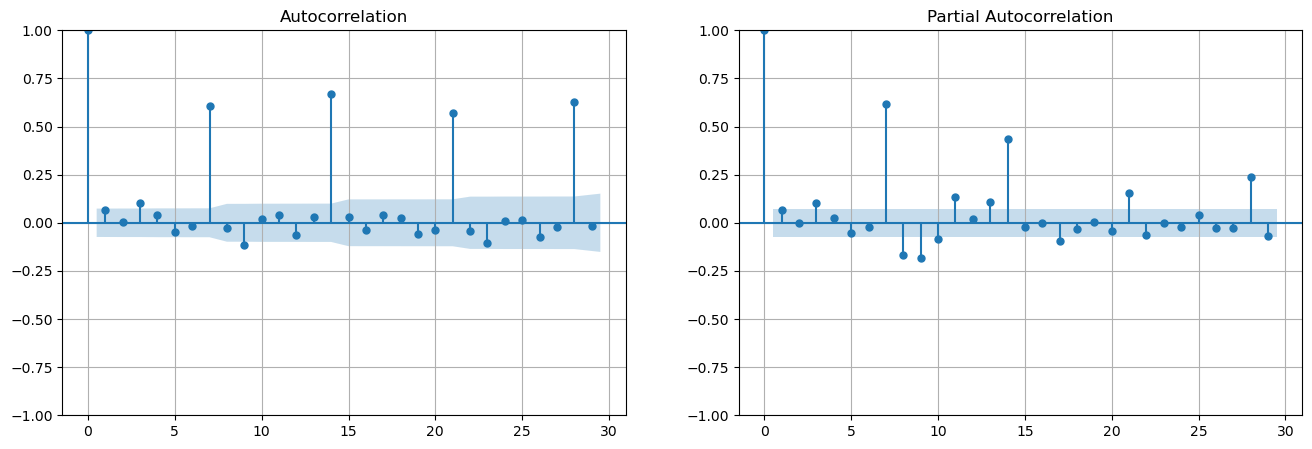

In [72]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
plot_acf(y_hist, ax = ax[0]);
ax[0].grid()
plot_pacf(y_hist, ax = ax[1], method = 'ywm');
ax[1].grid()

In [92]:
arma = ARIMA(y_hist['Sales'], order = (2, 0, 2)).fit()
print(arma.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  706
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -6427.976
Date:                Tue, 14 Nov 2023   AIC                          12867.953
Time:                        20:22:50   BIC                          12895.310
Sample:                    01-01-2013   HQIC                         12878.524
                         - 12-07-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5218.2887    301.189     17.326      0.000    4627.968    5808.609
ar.L1          0.1691      0.063      2.674      0.008       0.045       0.293
ar.L2          0.7946      0.058     13.730      0.0

### Making Predictions

In [74]:
hist_preds = arma.predict()

Model MAE: 1613.102533192201
Model RMSE: 2175.4723053791754
Model AICC: 12868.072742649822


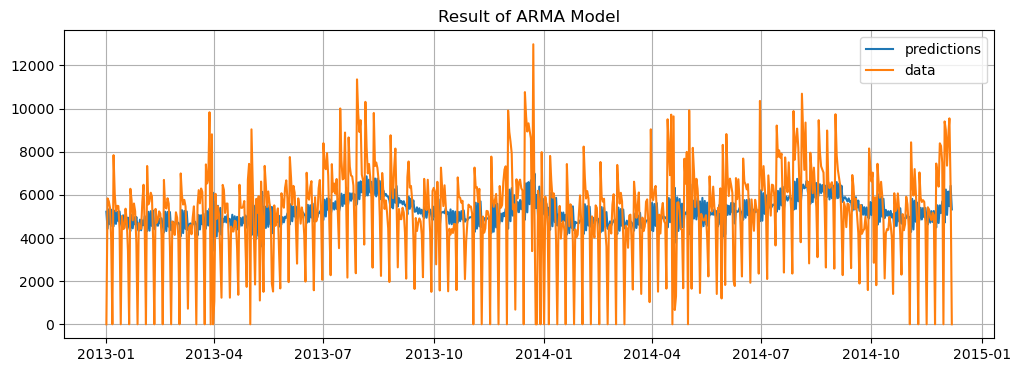

In [90]:
# Answer check
print(f"Model MAE: {arma.mae}")
print(f"Model RMSE: {np.sqrt(arma.mse)}")
print(f"Model AICC: {arma.aicc}")
plt.figure(figsize = (12, 4))
plt.plot(hist_preds, label = 'predictions')
plt.plot(y_hist, label = 'data')
plt.legend()
plt.grid()
plt.title('Result of ARMA Model');

### Forecasting with the ARMA model

In [76]:
future_preds = arma.forecast(steps = len(y_future))

Model MAE: 1613.102533192201
Model RMSE: 2175.4723053791754
Model AICC: 12868.072742649822


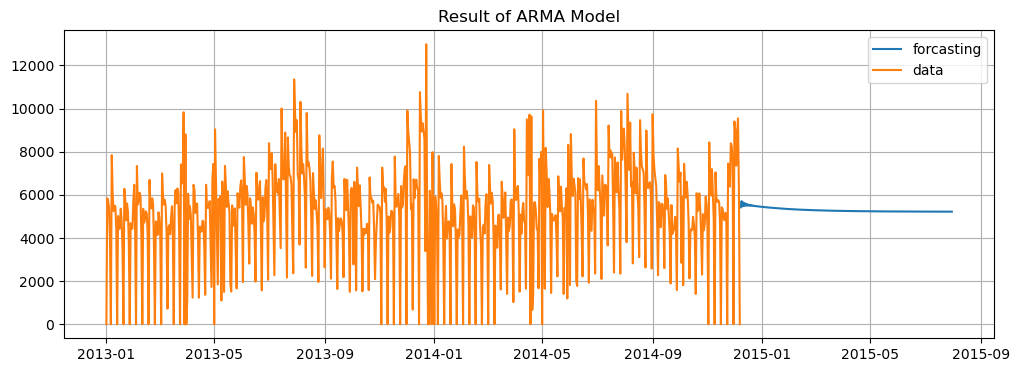

In [91]:
# Answer check
plt.figure(figsize = (12, 4))
plt.plot(future_preds, label = 'forcasting')
plt.plot(y_hist, label = 'data')
plt.legend()
plt.grid()
plt.title('Result of ARMA Model');
print(f"Model MAE: {arma.mae}")
print(f"Model RMSE: {np.sqrt(arma.mse)}")
print(f"Model AICC: {arma.aicc}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


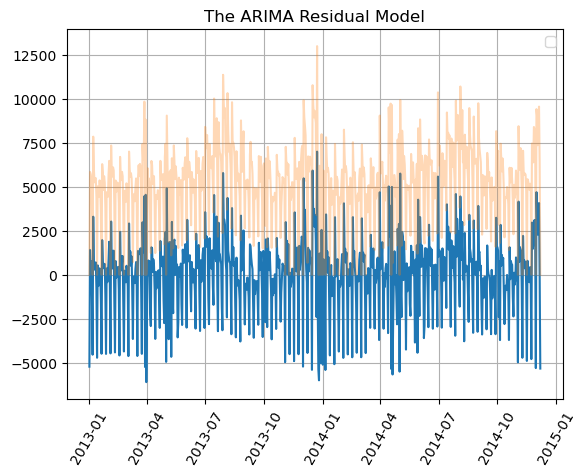

In [78]:
plt.plot(y_hist.index, arma.resid.values)
plt.plot(y_hist.index, y_hist, alpha = 0.3)
plt.xticks(rotation = 60)
plt.title('The ARIMA Residual Model')
plt.legend()
plt.grid();

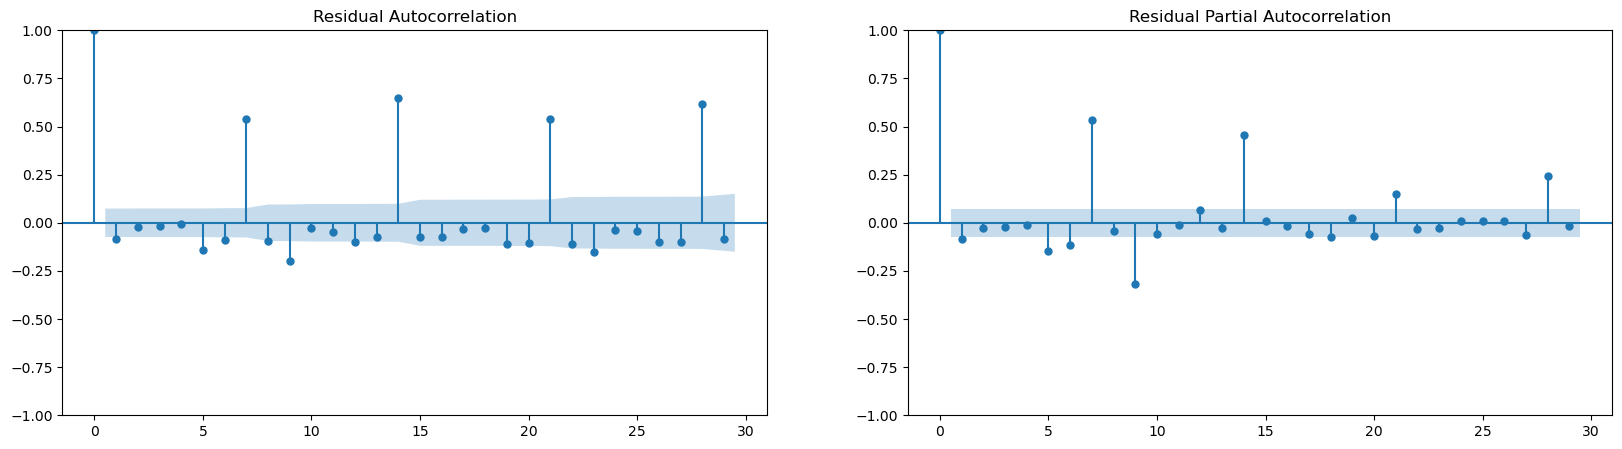

In [79]:
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
plot_acf(arma.resid, ax = ax[0]);
ax[0].set_title('Residual Autocorrelation')
plot_pacf(arma.resid, ax = ax[1]);
ax[1].set_title('Residual Partial Autocorrelation');

### Errors and Autocorrelation

In [80]:
dir(arma)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_cache',
 '_cov_approx_centered',
 '_cov_approx_complex_step',
 '_cov_params_approx',
 '_cov_params_oim',
 '_cov_params_opg',
 '_cov_params_robust_approx',
 '_cov_params_robust_oim',
 '_data_attr',
 '_data_attr_model',
 '_data_in_cache',
 '_fixed_params',
 '_fixed_params_index',
 '_free_params_index',
 '_get_previous_updated',
 '_get_robustcov_results',
 '_get_wald_nonlinear',
 '_has_fixed_params',
 '_init_kwds',
 '_news_previous_data',
 '_news_previous_results',
 '_news_updated_data',
 '_news_updated_results',
 '_params_ar',
 '_params_exog',
 '_params_ma',
 '_params_seasonal_ar',
 '_params_se

<Axes: xlabel='Date'>

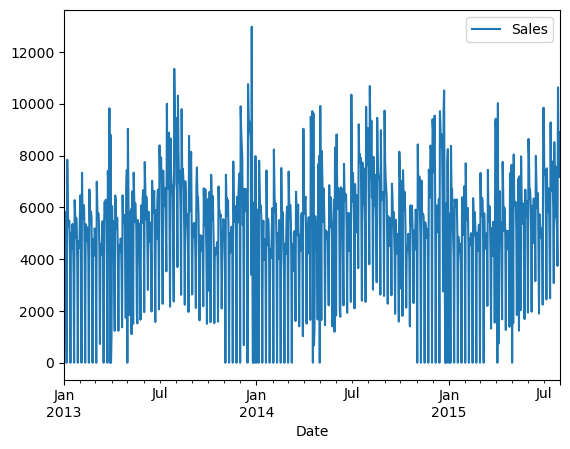

In [81]:
store_1.plot()

<Axes: xlabel='Date'>

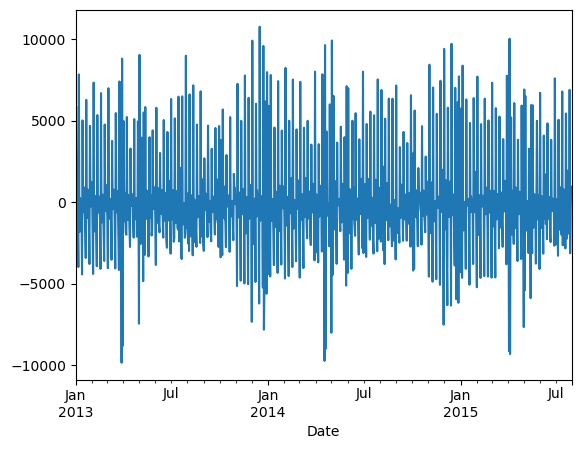

In [82]:
y = store_1['Sales'].diff()
y.plot()

<Axes: >

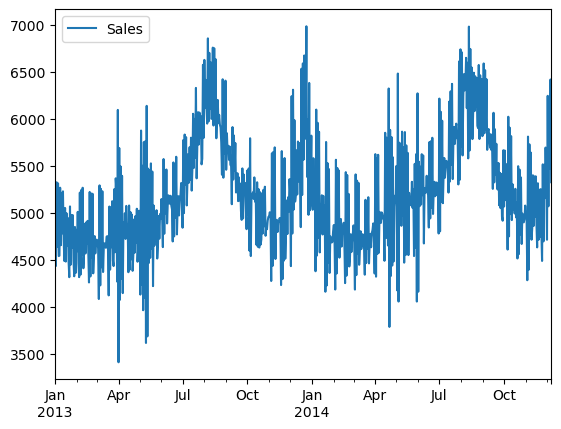

In [83]:
hist_preds = pd.DataFrame(hist_preds)
hist_preds.columns = ['Sales']
hist_preds.plot()

In [84]:
resids = y - hist_preds['Sales']
resids

2013-01-01            NaN
2013-01-02    1404.510947
2013-01-03   -5460.737439
2013-01-04   -4922.196547
2013-01-05   -6767.172977
                 ...     
2015-07-27            NaN
2015-07-28            NaN
2015-07-29            NaN
2015-07-30            NaN
2015-07-31            NaN
Name: Sales, Length: 942, dtype: float64

<Axes: >

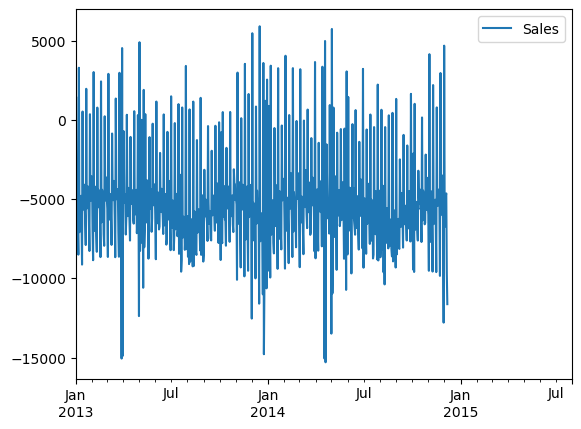

In [85]:
pd.DataFrame(resids).plot()

In [86]:
resids

2013-01-01            NaN
2013-01-02    1404.510947
2013-01-03   -5460.737439
2013-01-04   -4922.196547
2013-01-05   -6767.172977
                 ...     
2015-07-27            NaN
2015-07-28            NaN
2015-07-29            NaN
2015-07-30            NaN
2015-07-31            NaN
Name: Sales, Length: 942, dtype: float64

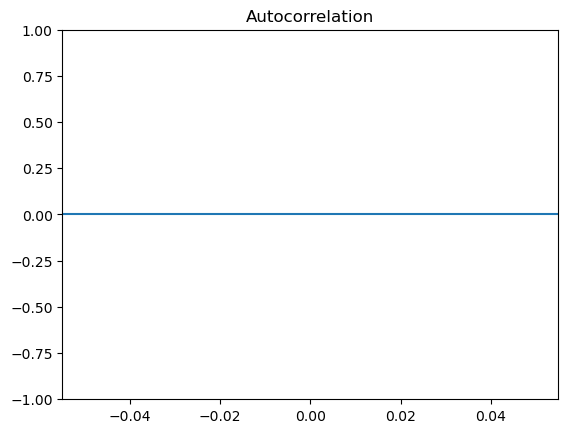

In [87]:
plot_acf(resids);

### Optimal Model 

In [93]:
import itertools
import math

# Original Parameters
# Define the range of values for p, d, q, P, D, Q, and m
# p_values = range(0, 3)  # Autoregressive order
# d_values = [0]          # Differencing order
# q_values = range(0, 3)  # Moving average order
# P_values = range(0, 2)  # Seasonal autoregressive order
# D_values = range(0, 1)  # Seasonal differencing order
# Q_values = range(0, 2)  # Seasonal moving average order
# m_values = [12]         # Seasonal period

# Define the range of values for p, d, q, P, D, Q, and m
p_values = range(2, 5, 10)  # Autoregressive order
d_values = [0,2]          # Differencing order
q_values = range(2, 5, 10)  # Moving average order
P_values = range(2, 5, 10)  # Seasonal autoregressive order
D_values = range(0, 2)  # Seasonal differencing order
Q_values = range(2,5,10)  # Seasonal moving average order
m_values = [4, 7, 12]         # Seasonal period

# Create all possible combinations of SARIMA parameters
param_combinations = list(itertools.product(p_values,
                                            d_values,
                                            q_values,
                                            P_values,
                                            D_values,
                                            Q_values,
                                            m_values))

# Initialize AIC with a large value
best_aic = float("inf")
best_params = None

# Perform grid search
for params in param_combinations:
    order = params[:3]
    seasonal_order = params[3:]

    try:
        model = SARIMAX(store_1,
                               order=order,
                               easonal_order=seasonal_order)
        result = model.fit(disp=False)
        aic = result.aic

        # Ensure the convergence of the model
        if not math.isinf(result.zvalues.mean()):
            print(order, seasonal_order, aic)

            if aic < best_aic:
                best_aic = aic
                best_params = params

        else:
            print(order, seasonal_order, 'not converged')

    except:
        continue

# Print the best parameters and AIC
print("Best Parameters:", best_params)
print("Best AIC:", best_aic)

(2, 0, 2) (2, 0, 2, 4) 17204.12485259785
(2, 0, 2) (2, 0, 2, 7) 17204.12485259785
(2, 0, 2) (2, 0, 2, 12) 17204.12485259785
(2, 0, 2) (2, 1, 2, 4) 17204.12485259785
(2, 0, 2) (2, 1, 2, 7) 17204.12485259785
(2, 0, 2) (2, 1, 2, 12) 17204.12485259785
(2, 2, 2) (2, 0, 2, 4) 17481.1157410803
(2, 2, 2) (2, 0, 2, 7) 17481.1157410803
(2, 2, 2) (2, 0, 2, 12) 17481.1157410803
(2, 2, 2) (2, 1, 2, 4) 17481.1157410803
(2, 2, 2) (2, 1, 2, 7) 17481.1157410803
(2, 2, 2) (2, 1, 2, 12) 17481.1157410803
Best Parameters: (2, 0, 2, 2, 0, 2, 4)
Best AIC: 17204.12485259785


In [ ]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                        print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
                    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = store_1
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=2315.837
ARIMA(1, 0, 1) RMSE=2289.888
ARIMA(1, 1, 2) RMSE=2282.120
ARIMA(2, 1, 2) RMSE=2274.111
ARIMA(4, 0, 2) RMSE=2085.132
ARIMA(6, 0, 2) RMSE=1944.044
ARIMA(6, 1, 0) RMSE=1895.134
ARIMA(6, 1, 1) RMSE=1871.190
ARIMA(6, 1, 2) RMSE=1850.024
ARIMA(8, 0, 0) RMSE=1811.758
ARIMA(8, 0, 1) RMSE=1785.746
